In [5]:
import numpy as np
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F

from competence_estimation.utils import load_data, get_network_weights, mix_open
from competence_estimation.scores  import create_score_function
from competence_estimation.metrics  import compute_metric

import pandas as pd
import matplotlib.pyplot as plt

# Short Introduction

The following files are required:
* {x}_id_train.pt
* {x}_id_val.pt
* {x}_id_test.pt
where x = features, logits, labels

and the same for ood samples:
* {x}_ood
where x = features, logits, labels

Additionally we require the weights w and biases b of the last layer

# Data and Config Loading

In [6]:
with open("config.yml", "r") as file:
    config = yaml.safe_load(file)

# Create Plot

In [7]:
# Here you have to include your own path
# dataset_path = "/home/DATA/ITWM/lorenzp/"
dataset="imagenet"
dataset_path = f"/home/lorenzp/workspace/competence_estimation/features/{dataset}"
# algorithm = "ERM"
model = "resnet18"

load_data = model
mode ="spatial"

w = torch.load(f"{dataset_path}/spatial/{model}_W.pt").numpy()
b = torch.load(f"{dataset_path}/spatial/{model}_b.pt").numpy()

print(w.shape, b.shape)

# Features/logits/labels Trainings data
features_id_train =  torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_train.pt")[:5000]
logits_id_train = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_train.pt")[:5000]
labels_id_train =  torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_train.pt")[:5000]

# Features/logits/labels Validation data
features_id_val = torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_train.pt")[5000:10000]
logits_id_val = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_train.pt")[5000:10000]
labels_id_val = torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_train.pt")[5000:10000]

# Features/logits/labels Test data
features_id_test = torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_test.pt")[:5000]
logits_id_test = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_test.pt")[:5000]
labels_id_test = torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_test.pt")[:5000]


print(
    features_id_train.shape,
    features_id_val.shape,
    features_id_test.shape
)

metrics = ['quantiles']
results = {}
results_frac = {}
results_id_test = {}
results_id_test_frac = {}
attacks = ['nor', 'fgsm', 'linfpgd', 'aa', 'linfdf', 'l2df']
# attacks = ['nor', 'fgsm']
score_fct = ["max_softmax", "max_logit", "vim", "mahalanobis", "knn", "energy", "energy_react", "GMM",  "PCA"]
# score_fct = ["max_softmax", "max_logit", "vim"]
# attacks = ['pgd']
# score_fct = [ "vim" ]

features_ood_clean = torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_test.pt")[5000:6000]
logits_ood_clean = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_test.pt")[5000:6000]
labels_ood_clean = torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_test.pt")[5000:6000]

(1000, 512) (1000,)
(5000, 512) (5000, 512) (5000, 512)


In [8]:
for it, attack in enumerate(attacks):
    print("attack: ", attack)
    results[attack] = {}
    results_frac[attack] = {}
    results_id_test[attack] = {}
    results_id_test_frac[attack] = {}
    
    if it == 0:
        features_ood = torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_test.pt")[6000:10000]
        logits_ood = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_test.pt")[6000:10000]
        labels_ood = torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_test.pt")[6000:10000]
    else:
        features_ood = np.squeeze(torch.load(f"{dataset_path}/spatial/features_{attack}_{mode}_{model}_test.pt"))[6000:10000]
        logits_ood = torch.load(f"{dataset_path}/spatial/logits_{attack}_{mode}_{model}_test.pt")[6000:10000]
        labels_ood = torch.load(f"{dataset_path}/spatial/labels_{attack}_{mode}_{model}_test.pt")[6000:10000]
    
    features_ood = np.vstack((features_ood_clean, features_ood))
    logits_ood = np.vstack((logits_ood_clean, logits_ood))
    labels_ood = np.concatenate((labels_ood_clean, labels_ood))    
    
    for it2, score_function_name in enumerate(score_fct):
        scores_id_val, score_function = create_score_function(
            features_id_train,
            logits_id_train,
            labels_id_train,
            features_id_val,
            logits_id_val,
            labels_id_val,
            w,
            b,
            score_function =  score_function_name,
            **config
        )
        scores_id_train = score_function(features_id_train, logits_id_train)
        scores_id_test  = score_function(features_id_test, logits_id_test)
        scores_ood_test = score_function(features_ood, logits_ood)
 
        outs = compute_metric(
            scores_id_val,
            scores_id_test,
            scores_ood_test,
            features_id_train,
            logits_id_train,
            labels_id_train,
            features_id_test,
            logits_id_test,
            labels_id_test,
            features_ood,
            logits_ood,
            labels_ood,
            metrics=metrics
        )

        print(score_function_name, outs)
        results[attack][score_function_name] = outs['n_95']
        results_frac[attack][score_function_name] = outs['n_95_frac']
        results_id_test[attack][score_function_name] = outs['n_95_id_test']
        results_id_test_frac[attack][score_function_name] = outs['n_95_frac_id_test']

attack:  nor
max_softmax {'n_95_frac': 0.9472, 'n_95': 0.8122888803482056, 'n_95_frac_id_test': 0.9498, 'n_95_id_test': 0.821014940738678}
max_logit {'n_95_frac': 0.931, 'n_95': 0.8189043998718262, 'n_95_frac_id_test': 0.9444, 'n_95_id_test': 0.8233799338340759}
vim {'n_95_frac': 0.4696, 'n_95': 0.8441226482391357, 'n_95_frac_id_test': 0.8392, 'n_95_id_test': 0.8050524592399597}


/home/lorenzp/IWR/competence_estimation/competence_estimation/scores.py:207: RuntimeWarning: Mean of empty slice.
  _m = fs.mean(axis=0)
/home/lorenzp/.conda/envs/ood/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


mahalanobis {'n_95_frac': 0.0, 'n_95': nan, 'n_95_frac_id_test': 0.0, 'n_95_id_test': nan}
knn {'n_95_frac': 0.3354, 'n_95': 0.7364341020584106, 'n_95_frac_id_test': 0.5796, 'n_95_id_test': 0.7035886645317078}
energy {'n_95_frac': 0.9182, 'n_95': 0.8179045915603638, 'n_95_frac_id_test': 0.9454, 'n_95_id_test': 0.8184895515441895}
energy_react {'n_95_frac': 0.9268, 'n_95': 0.8144152164459229, 'n_95_frac_id_test': 0.9486, 'n_95_id_test': 0.8150959014892578}
GMM {'n_95_frac': 0.4426, 'n_95': 0.7171260714530945, 'n_95_frac_id_test': 0.7298, 'n_95_id_test': 0.7259523272514343}
PCA {'n_95_frac': 0.5742, 'n_95': 0.7276210188865662, 'n_95_frac_id_test': 0.7844, 'n_95_id_test': 0.7419683933258057}
attack:  fgsm
max_softmax {'n_95_frac': 0.8138, 'n_95': 0.3258785903453827, 'n_95_frac_id_test': 0.9498, 'n_95_id_test': 0.821014940738678}
max_logit {'n_95_frac': 0.7692, 'n_95': 0.3442537784576416, 'n_95_frac_id_test': 0.9444, 'n_95_id_test': 0.8233799338340759}
vim {'n_95_frac': 0.4536, 'n_95': 0.4

/home/lorenzp/IWR/competence_estimation/competence_estimation/scores.py:207: RuntimeWarning: Mean of empty slice.
  _m = fs.mean(axis=0)
/home/lorenzp/.conda/envs/ood/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


mahalanobis {'n_95_frac': 0.0, 'n_95': nan, 'n_95_frac_id_test': 0.0, 'n_95_id_test': nan}
knn {'n_95_frac': 0.4254, 'n_95': 0.2881993353366852, 'n_95_frac_id_test': 0.5796, 'n_95_id_test': 0.7035886645317078}
energy {'n_95_frac': 0.7432, 'n_95': 0.35172227025032043, 'n_95_frac_id_test': 0.9454, 'n_95_id_test': 0.8184895515441895}
energy_react {'n_95_frac': 0.7524, 'n_95': 0.3474215865135193, 'n_95_frac_id_test': 0.9486, 'n_95_id_test': 0.8150959014892578}
GMM {'n_95_frac': 0.5698, 'n_95': 0.21902422606945038, 'n_95_frac_id_test': 0.7298, 'n_95_id_test': 0.7259523272514343}
PCA {'n_95_frac': 0.7132, 'n_95': 0.22209759056568146, 'n_95_frac_id_test': 0.7844, 'n_95_id_test': 0.7419683933258057}
attack:  linfpgd
max_softmax {'n_95_frac': 0.988, 'n_95': 0.23076923191547394, 'n_95_frac_id_test': 0.9498, 'n_95_id_test': 0.821014940738678}
max_logit {'n_95_frac': 0.9878, 'n_95': 0.23081596195697784, 'n_95_frac_id_test': 0.9444, 'n_95_id_test': 0.8233799338340759}
vim {'n_95_frac': 0.2416, 'n_9

/home/lorenzp/IWR/competence_estimation/competence_estimation/scores.py:207: RuntimeWarning: Mean of empty slice.
  _m = fs.mean(axis=0)
/home/lorenzp/.conda/envs/ood/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


mahalanobis {'n_95_frac': 0.0, 'n_95': nan, 'n_95_frac_id_test': 0.0, 'n_95_id_test': nan}
knn {'n_95_frac': 0.1524, 'n_95': 0.6732283234596252, 'n_95_frac_id_test': 0.5796, 'n_95_id_test': 0.7035886645317078}
energy {'n_95_frac': 0.9874, 'n_95': 0.22827628254890442, 'n_95_frac_id_test': 0.9454, 'n_95_id_test': 0.8184895515441895}
energy_react {'n_95_frac': 0.9866, 'n_95': 0.2286641001701355, 'n_95_frac_id_test': 0.9486, 'n_95_id_test': 0.8150959014892578}
GMM {'n_95_frac': 0.1378, 'n_95': 0.743105947971344, 'n_95_frac_id_test': 0.7298, 'n_95_id_test': 0.7259523272514343}
PCA {'n_95_frac': 0.1676, 'n_95': 0.7744629979133606, 'n_95_frac_id_test': 0.7844, 'n_95_id_test': 0.7419683933258057}
attack:  aa
max_softmax {'n_95_frac': 0.9022, 'n_95': 0.1744624227285385, 'n_95_frac_id_test': 0.9498, 'n_95_id_test': 0.821014940738678}
max_logit {'n_95_frac': 0.894, 'n_95': 0.17606264352798462, 'n_95_frac_id_test': 0.9444, 'n_95_id_test': 0.8233799338340759}
vim {'n_95_frac': 0.2152, 'n_95': 0.603

/home/lorenzp/IWR/competence_estimation/competence_estimation/scores.py:207: RuntimeWarning: Mean of empty slice.
  _m = fs.mean(axis=0)
/home/lorenzp/.conda/envs/ood/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


mahalanobis {'n_95_frac': 0.0, 'n_95': nan, 'n_95_frac_id_test': 0.0, 'n_95_id_test': nan}
knn {'n_95_frac': 0.2284, 'n_95': 0.4063047170639038, 'n_95_frac_id_test': 0.5796, 'n_95_id_test': 0.7035886645317078}
energy {'n_95_frac': 0.8964, 'n_95': 0.1726907640695572, 'n_95_frac_id_test': 0.9454, 'n_95_id_test': 0.8184895515441895}
energy_react {'n_95_frac': 0.899, 'n_95': 0.17241379618644714, 'n_95_frac_id_test': 0.9486, 'n_95_id_test': 0.8150959014892578}
GMM {'n_95_frac': 0.2532, 'n_95': 0.3475513458251953, 'n_95_frac_id_test': 0.7298, 'n_95_id_test': 0.7259523272514343}
PCA {'n_95_frac': 0.3096, 'n_95': 0.3372093141078949, 'n_95_frac_id_test': 0.7844, 'n_95_id_test': 0.7419683933258057}
attack:  linfdf
max_softmax {'n_95_frac': 0.9372, 'n_95': 0.16794708371162415, 'n_95_frac_id_test': 0.9498, 'n_95_id_test': 0.821014940738678}
max_logit {'n_95_frac': 0.9006, 'n_95': 0.17477236688137054, 'n_95_frac_id_test': 0.9444, 'n_95_id_test': 0.8233799338340759}
vim {'n_95_frac': 0.4326, 'n_95':

/home/lorenzp/IWR/competence_estimation/competence_estimation/scores.py:207: RuntimeWarning: Mean of empty slice.
  _m = fs.mean(axis=0)
/home/lorenzp/.conda/envs/ood/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


mahalanobis {'n_95_frac': 0.0, 'n_95': nan, 'n_95_frac_id_test': 0.0, 'n_95_id_test': nan}
knn {'n_95_frac': 0.3932, 'n_95': 0.23601220548152924, 'n_95_frac_id_test': 0.5796, 'n_95_id_test': 0.7035886645317078}
energy {'n_95_frac': 0.8532, 'n_95': 0.18143460154533386, 'n_95_frac_id_test': 0.9454, 'n_95_id_test': 0.8184895515441895}
energy_react {'n_95_frac': 0.8692, 'n_95': 0.178324893116951, 'n_95_frac_id_test': 0.9486, 'n_95_id_test': 0.8150959014892578}
GMM {'n_95_frac': 0.5424, 'n_95': 0.1622418910264969, 'n_95_frac_id_test': 0.7298, 'n_95_id_test': 0.7259523272514343}
PCA {'n_95_frac': 0.6808, 'n_95': 0.15334899723529816, 'n_95_frac_id_test': 0.7844, 'n_95_id_test': 0.7419683933258057}
attack:  l2df
max_softmax {'n_95_frac': 0.9138, 'n_95': 0.1722477525472641, 'n_95_frac_id_test': 0.9498, 'n_95_id_test': 0.821014940738678}
max_logit {'n_95_frac': 0.8782, 'n_95': 0.1792302429676056, 'n_95_frac_id_test': 0.9444, 'n_95_id_test': 0.8233799338340759}
vim {'n_95_frac': 0.4322, 'n_95': 0

/home/lorenzp/IWR/competence_estimation/competence_estimation/scores.py:207: RuntimeWarning: Mean of empty slice.
  _m = fs.mean(axis=0)
/home/lorenzp/.conda/envs/ood/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


mahalanobis {'n_95_frac': 0.0, 'n_95': nan, 'n_95_frac_id_test': 0.0, 'n_95_id_test': nan}
knn {'n_95_frac': 0.3944, 'n_95': 0.23529411852359772, 'n_95_frac_id_test': 0.5796, 'n_95_id_test': 0.7035886645317078}
energy {'n_95_frac': 0.8516, 'n_95': 0.18177548050880432, 'n_95_frac_id_test': 0.9454, 'n_95_id_test': 0.8184895515441895}
energy_react {'n_95_frac': 0.8694, 'n_95': 0.17828387022018433, 'n_95_frac_id_test': 0.9486, 'n_95_id_test': 0.8150959014892578}
GMM {'n_95_frac': 0.5414, 'n_95': 0.16254155337810516, 'n_95_frac_id_test': 0.7298, 'n_95_id_test': 0.7259523272514343}
PCA {'n_95_frac': 0.6778, 'n_95': 0.15402773022651672, 'n_95_frac_id_test': 0.7844, 'n_95_id_test': 0.7419683933258057}


In [9]:
keys = list(results.keys())
methods  = list(results[keys[0]].keys())

table = {}
table_frac = {}

for method in methods: 
    table[method] = []
    table_frac[method] = []
    
    for  key in keys:
        table[method].append(results[key][method])
        table_frac[method].append(results_frac[key][method])

In [11]:
torch.save(results, f'/home/lorenzp/workspace/competence_estimation/results/spatial_{dataset}.pt')

In [10]:
results = torch.load(f'/home/lorenzp/workspace/competence_estimation/results/spatial_{dataset}.pt')

In [ ]:
results_frac

In [12]:
results_id_test_frac

{'nor': {'max_softmax': 0.9498,
  'max_logit': 0.9444,
  'vim': 0.8392,
  'mahalanobis': 0.0,
  'knn': 0.5796,
  'energy': 0.9454,
  'energy_react': 0.9486,
  'GMM': 0.7298,
  'PCA': 0.7844},
 'fgsm': {'max_softmax': 0.9498,
  'max_logit': 0.9444,
  'vim': 0.8392,
  'mahalanobis': 0.0,
  'knn': 0.5796,
  'energy': 0.9454,
  'energy_react': 0.9486,
  'GMM': 0.7298,
  'PCA': 0.7844},
 'linfpgd': {'max_softmax': 0.9498,
  'max_logit': 0.9444,
  'vim': 0.8392,
  'mahalanobis': 0.0,
  'knn': 0.5796,
  'energy': 0.9454,
  'energy_react': 0.9486,
  'GMM': 0.7298,
  'PCA': 0.7844},
 'aa': {'max_softmax': 0.9498,
  'max_logit': 0.9444,
  'vim': 0.8392,
  'mahalanobis': 0.0,
  'knn': 0.5796,
  'energy': 0.9454,
  'energy_react': 0.9486,
  'GMM': 0.7298,
  'PCA': 0.7844},
 'linfdf': {'max_softmax': 0.9498,
  'max_logit': 0.9444,
  'vim': 0.8392,
  'mahalanobis': 0.0,
  'knn': 0.5796,
  'energy': 0.9454,
  'energy_react': 0.9486,
  'GMM': 0.7298,
  'PCA': 0.7844},
 'l2df': {'max_softmax': 0.9498,


In [ ]:
keys

In [ ]:
table.keys()

In [ ]:
results['nor']

In [ ]:
results['fgsm']

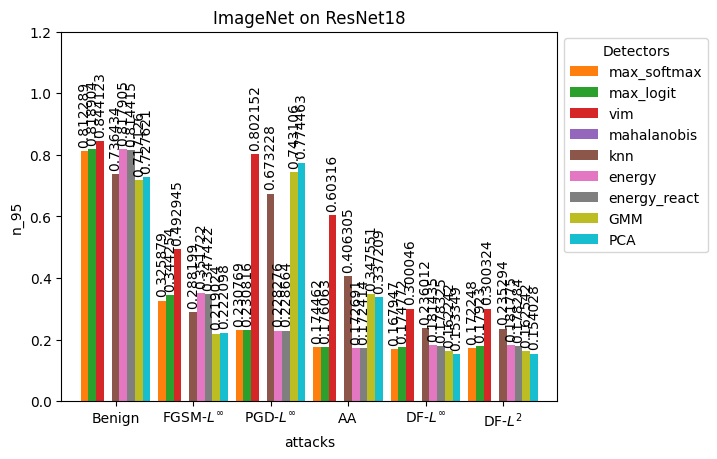

In [8]:
color=["#ff7f0e", "#2ca02c", '#d62728', '#9467bd', "#8c564b", "#e377c2", '#7f7f7f', '#bcbd22', '#17becf'][:len(table)]

raw_data = {
     'plan_type':  ['Benign', 'FGSM-$L^\infty$', 'PGD-$L^\infty$', 'AA', 'DF-$L^\infty$', 'DF-$L^2$'][:len(keys)],
}

for method in methods:
    raw_data[ method] = table[method]

df = pd.DataFrame(raw_data, columns=methods)
ax = df.plot.bar(rot=0, color=color[:len(table)], width=0.9)

for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x, h), xytext=(0, 3), rotation=90, 
                   textcoords="offset points", ha="center", va="bottom")

plt.title("ImageNet on ResNet18")
      
ax.set_ylim(0, 1.2)
ax.legend(title="Detectors", bbox_to_anchor=(1.0, 1), loc='upper left')
ax.set_xticklabels(raw_data["plan_type"])
plt.xlabel("attacks")
plt.ylabel("n_95")

plt.savefig(f"plots/{dataset}_{mode}_{model}_95.png", bbox_inches='tight', dpi=300)

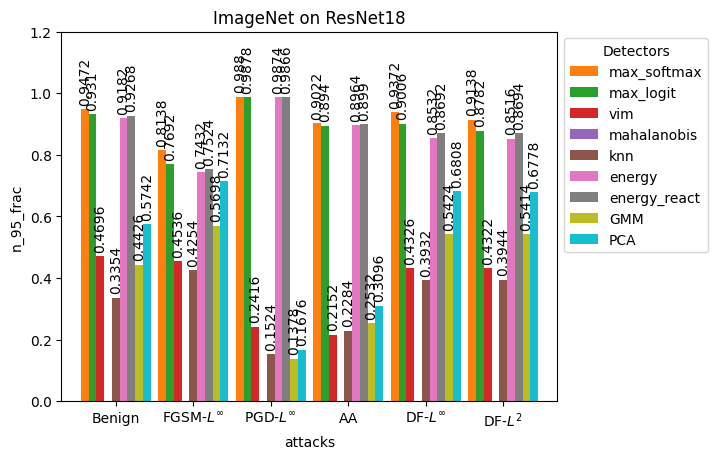

In [10]:
color=["#ff7f0e", "#2ca02c", '#d62728', '#9467bd', "#8c564b", "#e377c2", '#7f7f7f', '#bcbd22', '#17becf'][:len(table)]

raw_data = {
     'plan_type':  ['Benign', 'FGSM-$L^\infty$', 'PGD-$L^\infty$', 'AA', 'DF-$L^\infty$', 'DF-$L^2$'][:len(keys)],
}

for method in methods:
    raw_data[method] = table_frac[method]

df = pd.DataFrame(raw_data, columns=methods)
ax = df.plot.bar(rot=0, color=color[:len(table)], width=0.9)

for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x, h), xytext=(0, 3), rotation=90, 
                   textcoords="offset points", ha="center", va="bottom")

plt.title("ImageNet on ResNet18")
      
ax.set_ylim(0, 1.2)
ax.legend(title="Detectors", bbox_to_anchor=(1.0, 1), loc='upper left')
ax.set_xticklabels(raw_data["plan_type"])
plt.xlabel("attacks")
plt.ylabel("n_95_frac")

plt.savefig(f"plots/{dataset}_{mode}_{model}_95_frac.png", bbox_inches='tight', dpi=300)